In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import imutils
import traceback
from scipy.spatial import distance as dist

In [2]:
target_names = ['person', 'laptop', 'chair', 'tvmonitor', 'diningtable']

In [16]:
class YOLOV3:
    def __init__(self, targets):
        self.objects = {name:[] for name in targets} # {target_name:[(id, box, center)]}
        self.prev_objects = None # assign previos frame's ojects later in code
        self.target_names = targets
        self.net, self.output_layers, self.classes, self.targets = self.load_yolo(self.target_names)
        
    def load_yolo(self, targets):
        # Load Yolo
        net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
        net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)
        net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
        with open("coco.names", "r") as f:
            classes = [line.strip() for line in f.readlines()]
        targets = np.array([np.where(np.array(classes) == target) for target in target_names]).flatten() # find index of wanted targets
        #print(targets)
        layer_names = net.getLayerNames()
        output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
        
        return net, output_layers, classes, targets

    def detect_objects(self, size=(320,320), swapRB=True, crop=False, scalefactor=0.00392):
        # Detecting objects
        blob = cv2.dnn.blobFromImage(self.img, scalefactor, size, (0, 0, 0), swapRB, crop=crop)
        self.net.setInput(blob)
        outs = self.net.forward(self.output_layers)
    
        self.outs = outs
    
    # Showing informations on the screen
    def find_indexes(self, conf=0.9):
        self.class_ids = []
        self.centroids = []
        self.result = []
        self.confidences = []
        self.boxes = []
        self.centers = []
        dims = self.img.shape
        for out in self.outs:
            for detection in out:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                if confidence > conf and class_id in self.targets:
                    # Object detected
                    center_x = int(detection[0] * dims[1])
                    center_y = int(detection[1] * dims[0])
                    w = int(detection[2] * dims[1])
                    h = int(detection[3] * dims[0])

                    # Rectangle coordinates
                    x = int(center_x - w / 2)
                    y = int(center_y - h / 2)

                    self.boxes.append([x, y, w, h])
                    self.centers.append((center_x, center_y))
                    self.confidences.append(float(confidence))
                    self.class_ids.append(class_id)

        self.indexes = cv2.dnn.NMSBoxes(self.boxes, self.confidences, 0.5, 0.4) # non max suppression
        
    def midpoint(ptA, ptB):
        return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)
    
    def find_NMS_boxes(self):
        self.prev_objects = self.objects # set previous objects before resetting
        self.objects = {name:[] for name in self.target_names} # clear 'prev' objects
        self.distance=[]
        try:
            for i in self.indexes:
                label = str(self.classes[self.class_ids[i[0]]])
                box = self.boxes[i[0]]
                center = self.centers[i[0]]
                self.objects[label].append((i[0], box, center)) # {target_name:[(id, [box], (center)]}
            #print(self.objects['tvmonitor'][1][1][0])
        except KeyError:
            print('key '+ label + 'not found')

      
    def find_distance(self,mindistance = 70):              
        for i in range(len(self.objects['person'])):
            for j in range(len(self.objects['tvmonitor'])):
                ecdistance=dist.euclidean((self.objects['person'][i][2]),self.objects['tvmonitor'][j][2])/2.5
                self.distance.append(ecdistance)
                cv2.line(self.img, self.objects['person'][i][2], self.objects['tvmonitor'][j][2],(255, 0, 0), 1)
                xA,yA=self.objects['person'][i][2]
                xB,yB=self.objects['tvmonitor'][j][2]
                mX,mY = YOLOV3.midpoint((xA, yA), (xB, yB))
                cv2.putText(self.img, "{:.1f}in".format(ecdistance), (int(mX), int(mY - 10)),cv2.FONT_HERSHEY_SIMPLEX, 
                            0.35, (255, 0, 0), 1)
                if ecdistance < mindistance:
                    x=self.objects['tvmonitor'][j][1][0]
                    y=self.objects['tvmonitor'][j][1][1]
                    w=self.objects['tvmonitor'][j][1][2]
                    h=self.objects['tvmonitor'][j][1][3]
                    cv2.rectangle(self.img, (x, y), (x + w, y + h), (255, 0, 0), 2)
        #print(self.distance)
    
    def draw_boxes_labels(self, colors=(0,255,0)):
        font = cv2.FONT_HERSHEY_PLAIN
        height, width, dim = self.img.shape
        rect_thicc = int(height/70)
        if height < 70:
            rect_thicc = 1
        self.find_NMS_boxes()
        for label in self.target_names:
            for obj in self.objects[label]:   
                x, y, w, h = obj[1] # obj[1] = box
                font_size = int(height/300)+1
                font_width = int(height/200)+1
                lbl = label
                color = colors
                cv2.rectangle(self.img, (x, y), (x + w, y + h), color, rect_thicc)
                cv2.circle(self.img, obj[2], rect_thicc*2, (0,255,0), thickness=rect_thicc)
                cv2.putText(self.img, lbl + ' ' + str(obj[0]), (x, y - font_size), font, font_size, color, font_width)
  
    def yolo_frame(self, img):
        img = cv2.resize(img, None, fx=1, fy=1) # resize image
        self.img = img
        self.detect_objects() # find all objects
        self.find_indexes(.7) # box object if object in targets
        self.draw_boxes_labels() # update frame
        self.find_distance(60)
        return img
    
    def yolo_video(self, filename):
        prev_frame_time = 0
        cap=cv2.VideoCapture(filename)
        if cap.isOpened() == False: 
            print("Error opening video stream or file")
        t1 = time.time()
        while cap.isOpened():
                success, img=cap.read()
                if success == True:
                    if time.time() - t1 > .6:
                        gray = img
                        font = cv2.FONT_HERSHEY_SIMPLEX
                        new_frame_time = time.time()
                        fps = 1/(new_frame_time-prev_frame_time) 
                        prev_frame_time = new_frame_time 
                        fps = int(fps)
                        fps = str(fps)
                        cv2.putText(gray, fps, (7, 70), font, 1, (100, 255, 0), 3, cv2.LINE_AA)
                        #open final window
                        t = time.time()
                        img = self.yolo_frame(img)
                        #print(time.time() - t)
                        #open final window
                        cv2.imshow('img', img)
                        t1 = time.time()
    #               cv2.imshow('img', frame)
                #press q to quite the window
                    if cv2.waitKey(25) & 0xFF == ord('q'):
                        break
                else:
                    break
        cap.release()
        cv2.destroyAllWindows()

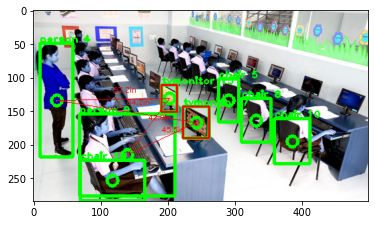

In [18]:
img = cv2.imread('lab1.png')
YOLO = YOLOV3(target_names)

plt.imshow(YOLO.yolo_frame(img))
YOLO.yolo_video(filename='conv2B test3.mp4')